Import Dependencies

In [9]:
from ctypes import c_int

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy import stats
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score,make_scorer

Load  data into a  DataFrame

In [10]:
# Load the data
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')

# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'CCS','Mass','Charge', 'Length']]
#mb_clean_frame["length"] = len(mb_clean_frame["sequence"])
# Group by 'Sequence' and 'Charge', and calculate median of 'Mass' and 'CCS'
mb_clean_frame = mb_clean_frame.groupby(['Sequence', 'Charge']).agg({'Mass':'median', 'CCS':'median', 'Length': 'median'}).reset_index()
# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# Save the mean and std for later use
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# Delete the raw data frame to save memory
del mb_raw_data
# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

Train Model

In [11]:
# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[["Charge", "Mass", "Length"]]
y = mb_clean_frame['CCS_z']
# Define the number of folds
k = 4

Perform k-fold cross validation

In [12]:
# Start logging time in ms without
start_time = time.time()
# Initialize the cross-validation object
kf = KFold(n_splits=k)
# Initialize a list to store the MSE for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a PolynomialFeatures object
    poly = PolynomialFeatures(degree=3)

    # Fit and transform the training data
    #X_train_poly = poly.fit_transform(X_train)

    # Create a linear regression model
    model = LinearRegression(n_jobs=-1)

    model.fit(X_train, y_train)
    #X_test_poly = poly.transform(X_test)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predictions back to original scale
    y_pred_orig = y_pred * ccs_std + ccs_mean
    y_test_orig = y_test * ccs_std + ccs_mean

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test_orig, y_pred_orig)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

#poly = PolynomialFeatures(degree=3)

#X_poly = poly.fit_transform(X)

# Create the final model
final_model = LinearRegression(n_jobs=-1)
final_model.fit(X, y)

# Print the average MSE score
print("Average Mean Squared Error:", np.mean(mse_scores))
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 1.1197322962231657e-72
Average Median Relative Error: 0.03321281303928507
Average R^2 Score: 0.9832896122833029
Time elapsed: 0.18 seconds


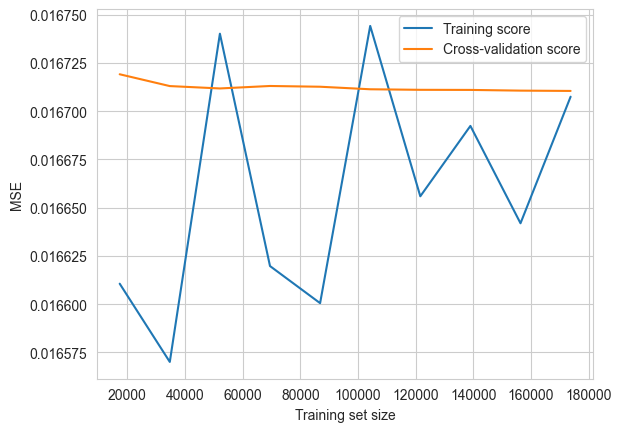

In [13]:
from sklearn.model_selection import learning_curve

# Define the sizes of the training sets to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(n_jobs=-1),
    X,
    y,
    train_sizes=train_sizes,
    cv=k,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate the average training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.legend()
plt.show()


Feature: 0, Score: 1.69510
Feature: 1, Score: -0.00058
Feature: 2, Score: -0.00723


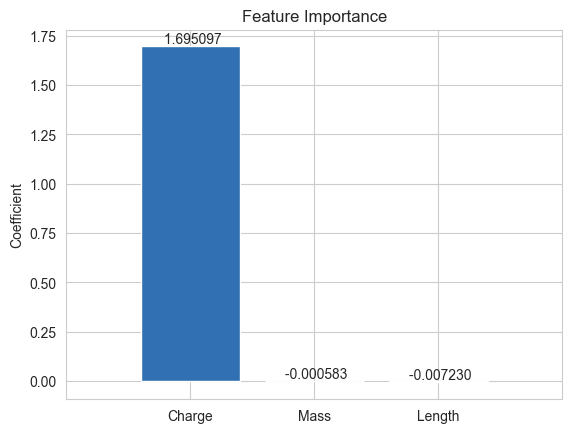

In [14]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color="#3070B3")
plt.title("Feature Importance")
plt.ylabel("Coefficient")
features = X.columns
plt.xticks(range(X.shape[1]), model.feature_names_in_, rotation=0)
plt.xlim([-1, X.shape[1]])

for i, v in enumerate(importance):
    plt.text(i, v, " %.6f" % v, ha='center', va='bottom')

plt.show()

In [15]:

def median_relative_error(y_true, y_pred):
    return np.median(np.abs((y_pred - y_true) / y_true))

scorer = make_scorer(median_relative_error, greater_is_better=False)

In [16]:
train_sizes = np.linspace(0.01, 1.0, 100)

model = LinearRegression(n_jobs=-1)

def median_relative_error(y_true, y_pred):
    y_pred_orig = y_pred * ccs_std + ccs_mean
    y_true_orig = y_true * ccs_std + ccs_mean
    return np.median(np.abs((y_pred_orig - y_true_orig) / y_true_orig))

median_relative_error_scores = []
R2_scores = []
data_sizes = []

for train_size in tqdm(train_sizes):
    kf = KFold(n_splits=k)
    data = mb_clean_frame.sample(frac=train_size, random_state=1)
    X = data[['Mass', 'Charge', 'Length']]
    y = data['CCS_z']
    data_sizes.append(len(data))
    median_relative_errors = []
    r2_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LinearRegression(n_jobs=-1)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_pred_orig = y_pred * ccs_std + ccs_mean
        y_test_orig = y_test * ccs_std + ccs_mean


        relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
        median_relative_error = np.median(relative_errors)
        median_relative_errors.append(median_relative_error)

        r2 = r2_score(y_test_orig, y_pred_orig)
        r2_scores.append(r2)

    median_relative_error_scores.append(np.mean(median_relative_errors))
    R2_scores.append(np.mean(r2_scores))

100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


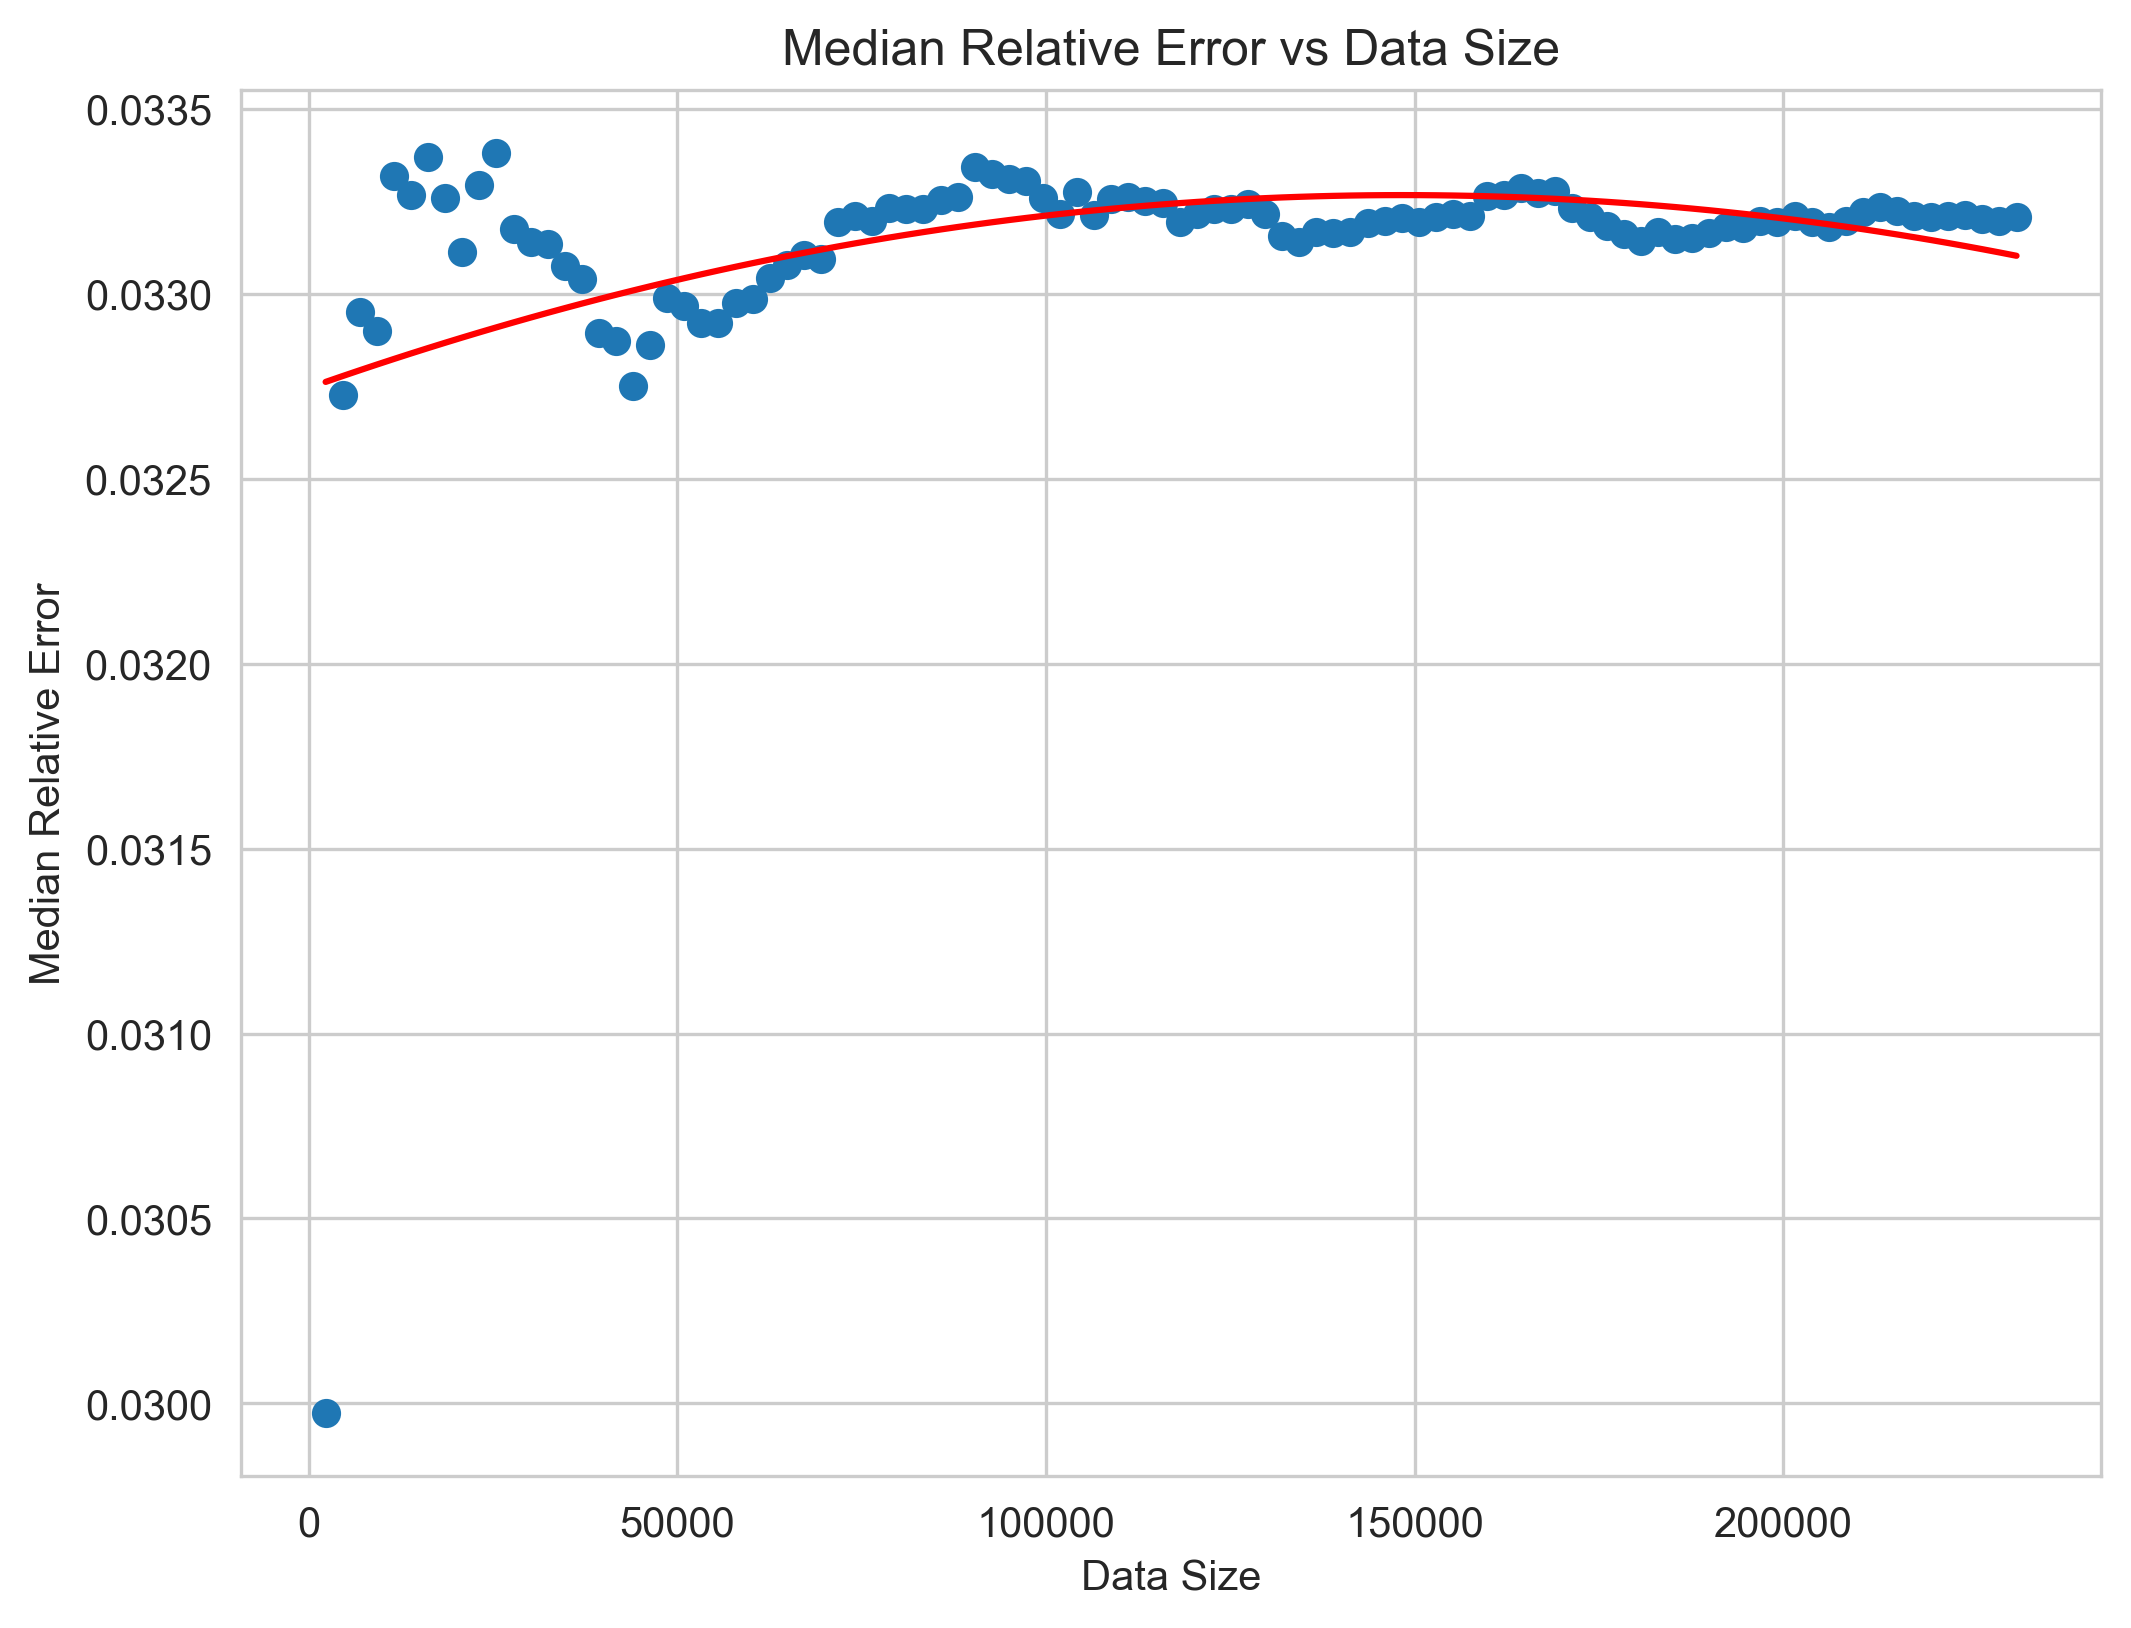

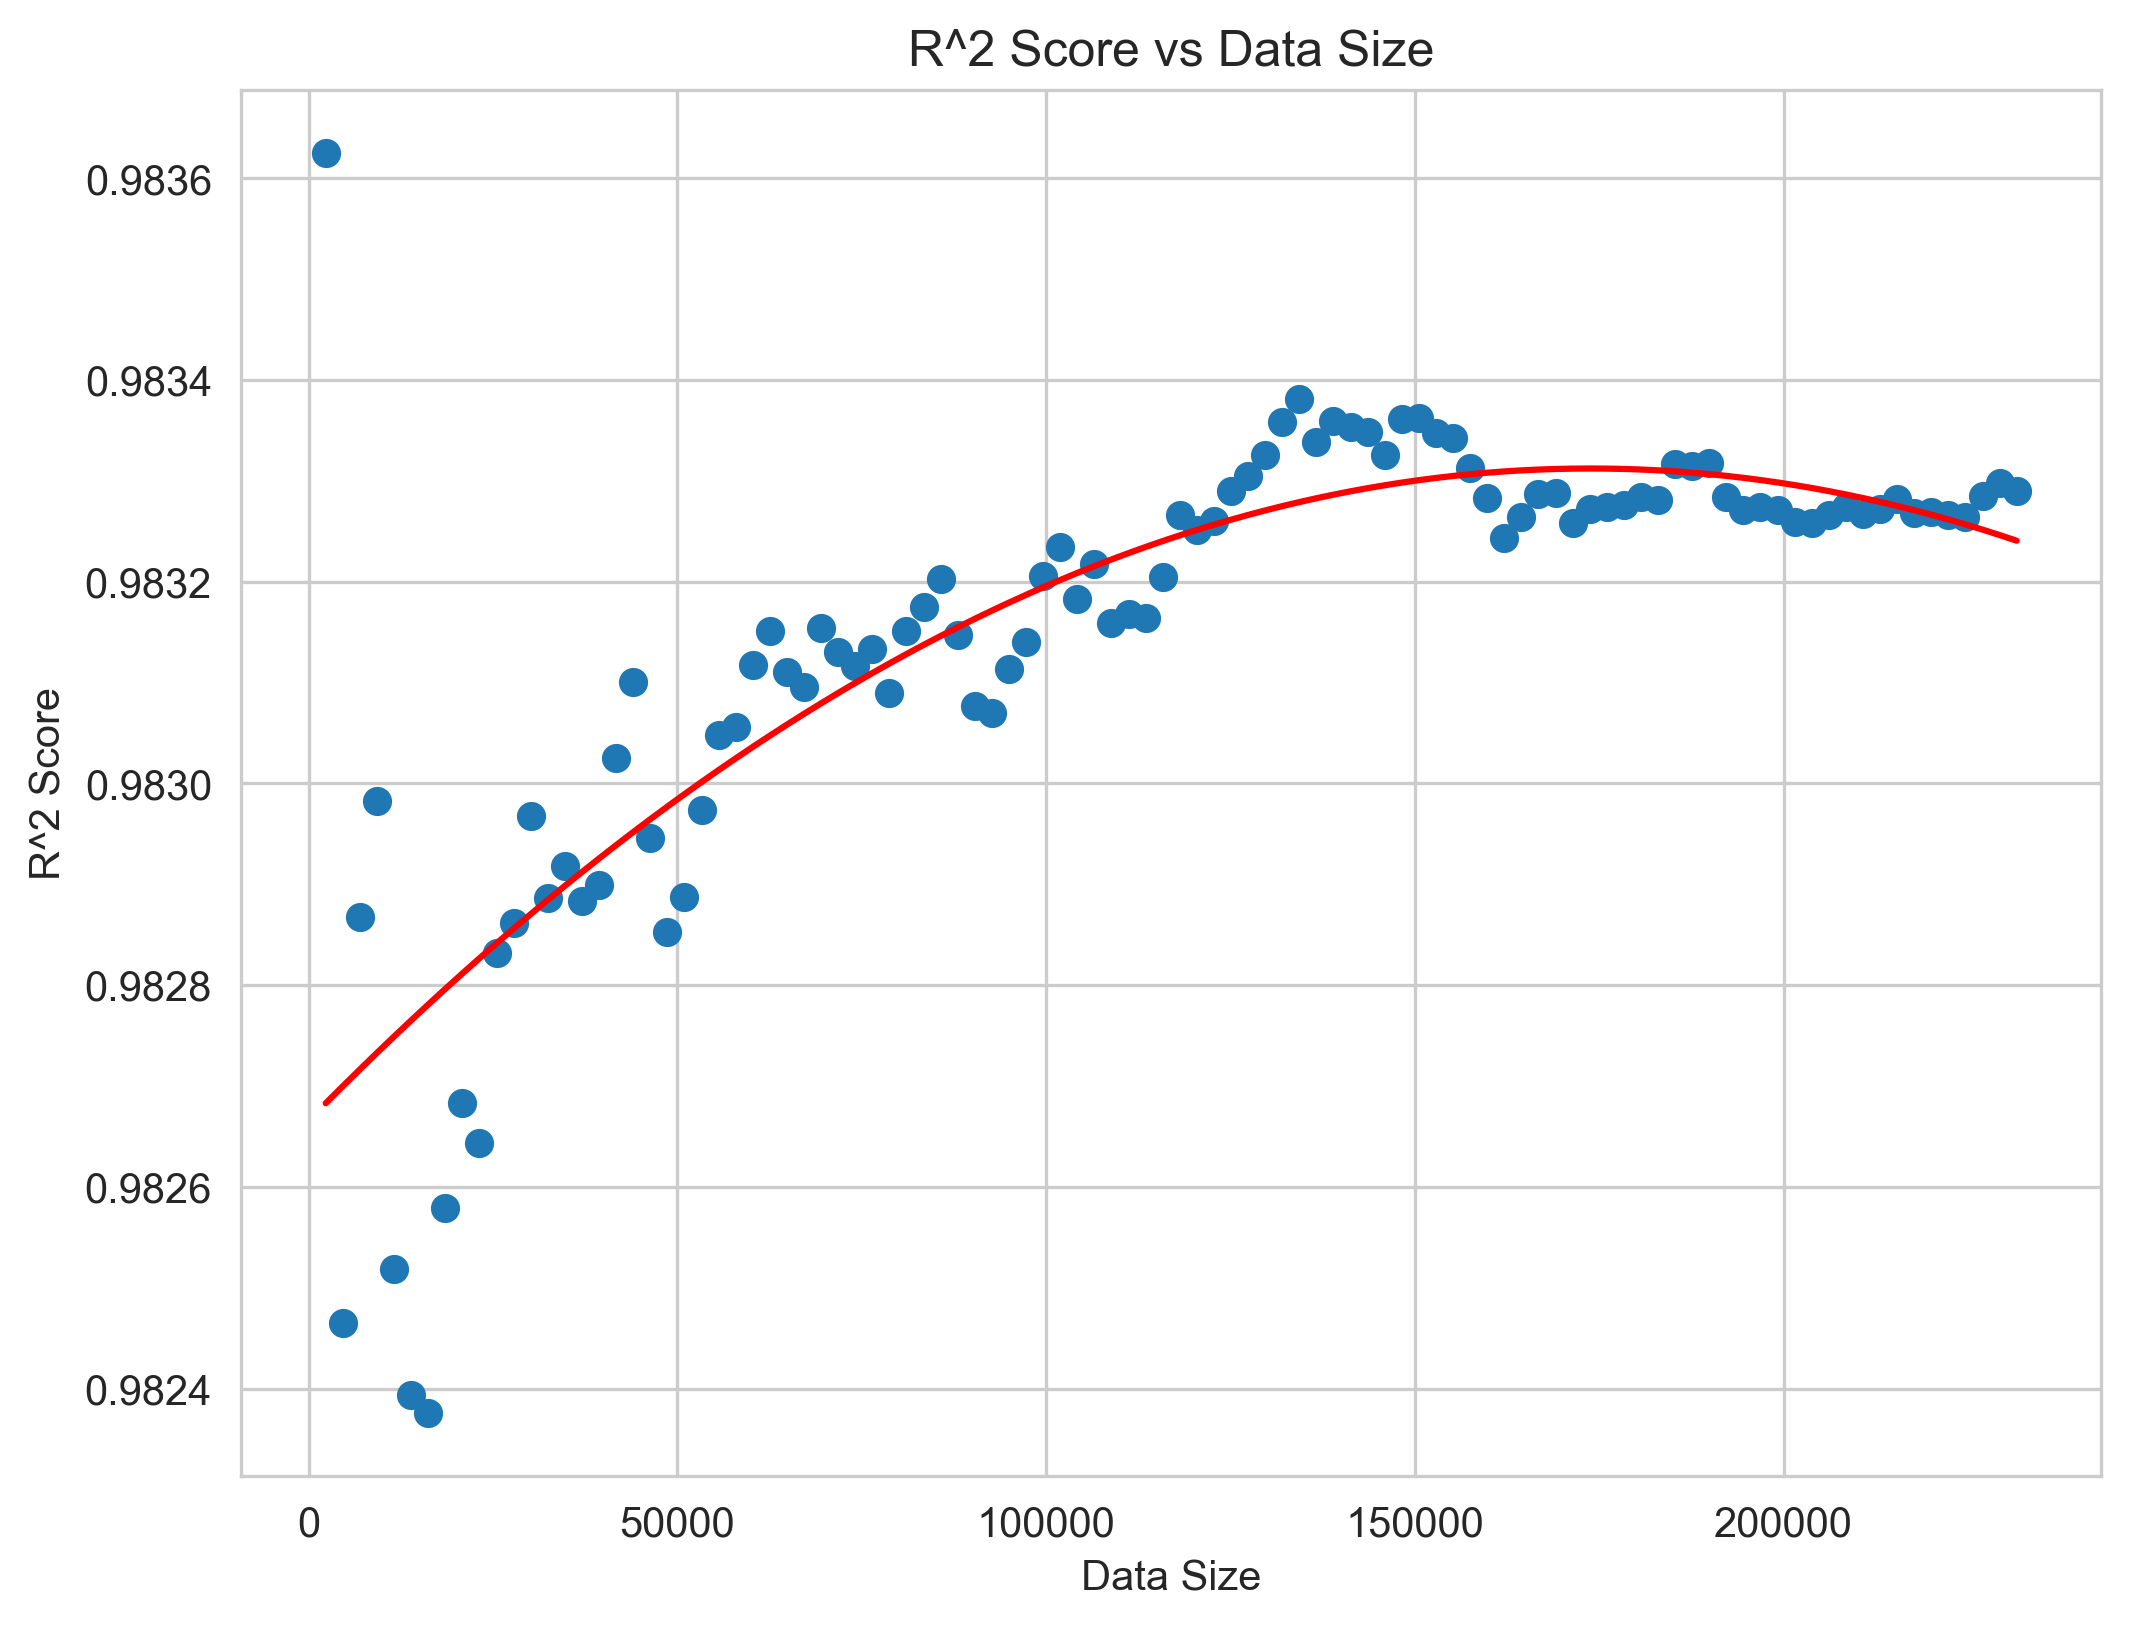

In [17]:
# Plot Median Relative Error with trendline
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(data_sizes, median_relative_error_scores, marker='o')
coeffs = np.polyfit(data_sizes, median_relative_error_scores, 2)
poly = np.poly1d(coeffs)
plt.plot(sorted(data_sizes), poly(sorted(data_sizes)), color='red')
plt.title('Median Relative Error vs Data Size')
plt.xlabel('Data Size')
plt.ylabel('Median Relative Error')
plt.grid(True)
plt.show()

# Plot R^2 Scores with trendline
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(data_sizes, R2_scores, marker='o')
coeffs = np.polyfit(data_sizes, R2_scores, 2)
poly = np.poly1d(coeffs)
plt.plot(sorted(data_sizes), poly(sorted(data_sizes)), color='red')
plt.title('R^2 Score vs Data Size')
plt.xlabel('Data Size')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.show()

Save the model

In [18]:
# Predict the CCS of the peptides in the data frame
mb_clean_frame['Predicted CCS'] = final_model.predict(X)

# Reverse the z-score transformation
mb_clean_frame['Predicted CCS'] = mb_clean_frame['Predicted CCS'] * ccs_std + ccs_mean


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))
# Create a scatter plot between the percent error and length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)



In [ ]:
ccs_data = mb_clean_frame["CCS"].to_numpy()
predicted_ccs_data = mb_clean_frame["Predicted CCS"].to_numpy()


x = mb_clean_frame["CCS"]
y = mb_clean_frame["Predicted CCS"]

plt.hist2d(x, y, bins=[30,30],norm=colors.LogNorm(), range=((3*1e-36, 4.7*1e-35), (3*1e-36, 4.7*1e-35)))
plt.xlabel("Experimental CCS")
plt.ylabel("Predicted CCS")
plt.colorbar()
plt.show()


In [ ]:
boundaries = [0.5, 1.5, 2.5, 3.5, 4.5]
cmap = colors.ListedColormap(['orange', 'blue', 'green', 'red'])

norm = BoundaryNorm(boundaries, cmap.N, clip=True)

fig, ax = plt.subplots()

scatter = ax.scatter(
    x=mb_clean_frame['CCS'],
    y=mb_clean_frame['Predicted CCS'],
    c=mb_clean_frame['Charge'],
    cmap=cmap,
    norm=norm,
    alpha=0.2
)
ax.set_xlabel('Experimental CCS')
ax.set_ylabel('Predicted CCS')

cbar = plt.colorbar(scatter, ticks=[1, 2, 3, 4])
cbar.set_label('Charge')

plt.show()

Save the model to a file

In [ ]:
#filename = '../../models/lin_reg/lin_reg.pkl'
#pickle.dump(model, open(filename, 'wb'))